# Stereotype-category interactions

Here we follow-up Stolier & Freeman (2016 - Nature Neuroscience) to see if individual differences in stereotype-driven category interactions are reflected in the brain. That is, we want to assess whether participants who believe black-male stereotype overlap is more similar than black-female stereotype overlap, also show more simliar neural responses between looking at black and male faces, compared to black and female faces. 

In other words, we test if the brain is processing black as more similar to male than female in individuals who stereotype black as more similar to male than female.

First, let's load in the data.

## Data loading

In [2]:
from env_analysis import *
from scipy.stats import spearmanr
%matplotlib inline
import seaborn as sns
from IPython.display import display
import glob

Let's prepare the data, creating patterns for black (male and female), male (white), and female (white).

In [3]:
for s in data:
    data[s].sa['targets'] = ['b' if i[0] == 'b' else i[1] for i in data[s].sa.targets]
print('new targets',np.unique([data[s].UT for s in data]))

('new targets', array(['b', 'f', 'm'],
      dtype='|S1'))


# ROI analysis

First, let's analyze the FG and OFC ROIs identified in Stolier & Freeman, 2016 - Nature Neuroscience.

The most intuitive way is a pairsim ANOVA, seeing if black is closer to male than female, and whether individual differences in the stereotype overlap of these categories predicts neural pattern similarity (i.e., do subjects with a stronger black-male vs. black-female stereotype overlap have more similar black-male than black-female neural patterns).

## Pairsim ANOVA

On average, is black-male more similar than black-female?

In [4]:
bm_bf_pairsims = pd.DataFrame(roi_pairsim_nSs(data,'ROIs/roimask_rFG_original.nii.gz',[['b','m'],['b','f']],fisherz=1)).transpose()
print(scipy.stats.ttest_rel(bm_bf_pairsims['b-f'],bm_bf_pairsims['b-m']))

Ttest_relResult(statistic=0.56481023964713406, pvalue=0.57818705181604257)


## Individual differences in stereotype overlap

From each subject's explicit stereotype overlap DM, let's get their black-male and black-female overlap, and, particularly, the difference between the two.

First, let's prepare the data.

In [5]:
exp_data = [[1-squareform(DMs.Exp7x7[s])[6],1-squareform(DMs.Exp7x7[s])[8],(1-squareform(DMs.Exp7x7[s])[8])-(1-squareform(DMs.Exp7x7[s])[6])] for s in bm_bf_pairsims.index.values]
exp_data = pd.DataFrame(exp_data,columns=['expBF','expBM','expBM_m_BF'],index=bm_bf_pairsims.index.values)
bm_bf_data = pd.concat([bm_bf_pairsims,exp_data],axis=1)
bm_bf_data['bm_bf'] = bm_bf_data['b-m'] - bm_bf_data['b-f']
display(bm_bf_data)

,b-f,b-m,expBF,expBM,expBM_m_BF,bm_bf
669,-0.674501,-1.070686,-0.105727,0.019033,0.124760,-0.396186
675,-0.946769,-0.539543,0.057885,0.034193,-0.023692,0.407226
679,-0.970484,-1.187663,0.006691,0.068385,0.061694,-0.217179
680,-0.602375,-0.672666,0.496418,0.132380,-0.364039,-0.070291
683,-0.463430,-0.743049,-0.384235,-0.002991,0.381244,-0.279618
686,-0.609331,-0.579112,0.707201,0.167384,-0.539817,0.030219
687,-1.119413,-0.694410,0.397418,-0.198341,-0.595759,0.425002
690,-0.630877,-1.055084,0.138168,0.167163,0.028995,-0.424207
691,-0.210943,-0.654650,-0.230452,0.256986,0.487437,-0.443707
692,-0.647966,-0.421188,0.056201,0.341221,0.285020,0.226779


Is the similarity in stereotypes related to the similarity in neural patterns?

(-0.37228462364995957, 0.087971060798490305)


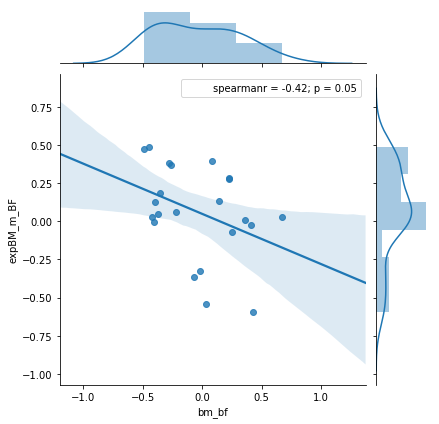

In [7]:
print(pearsonr(bm_bf_data['bm_bf'],bm_bf_data['expBM_m_BF']))
sns.jointplot("bm_bf", "expBM_m_BF", data=bm_bf_data, kind="reg", stat_func=spearmanr)

### Nope. Lol.

---

# Whole-brain analysis

Now, let's prepare the whole-brain analysis. This should be run in background due to time consumption. Not here, in a jupyter-notebook.

```
slres = sl_pairsim_nSs(data,[['b','m'],['b','f']],h5=1,h5out='slPairsim_bm_bf.hdf5')
# save data
mkdir('slPairsim_bm_bf')
for d in slres:
    ds2nifti(slres[d],data[d[:3]],'./slPairsim_bm_bf/%s.nii.gz' % d)
```

In our first analysis, we test for the main effect: where is black-male more similar than black-female?

In [14]:
# load data
data = dict( [ (f.split('/')[1][:7],fmri_dataset(f,mask='4fcii_unionmask.nii.gz')) for f in glob.glob('slPairsim_bm_bf/*') ] )

In [16]:
# stack data into 3D dataset (subject,target-pair,voxel)
data_subj = dict( [ (s,np.vstack([data[s+'-b-m'],data[s+'-b-f']])) for s in np.unique([f[:3] for f in data]) ] )
data_subj_mf = np.dstack(data_subj.values())

In [17]:
# calculate related t-test in each voxel (m-b - m-f)
res = np.array( [scipy.stats.ttest_rel(data_subj_mf[:,i,:][0],data_subj_mf[:,i,:][1]) for i in range(data_subj_mf.shape[1])])
ds2nifti(res.transpose()[0],data[data_subj.keys()[0]+'-b-m'],'ttest_paired_mb_fb.nii.gz')

If you specified threshold, ignore unthreshold warning
Plotting unthresholded image


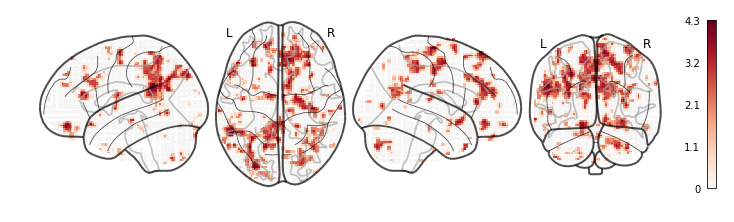

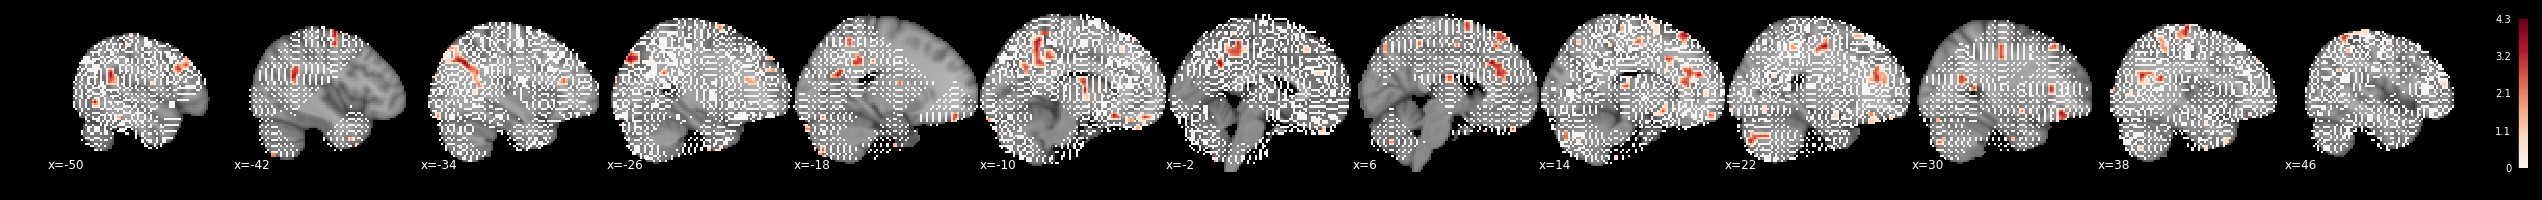

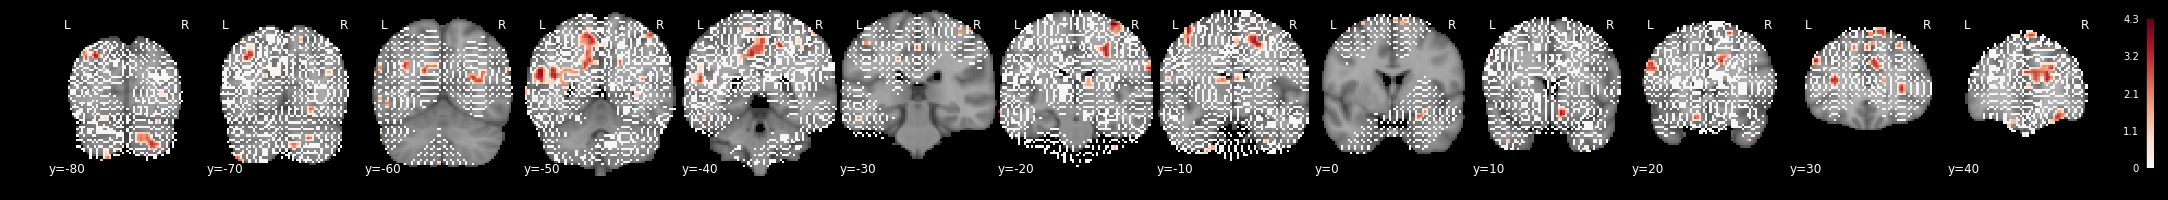

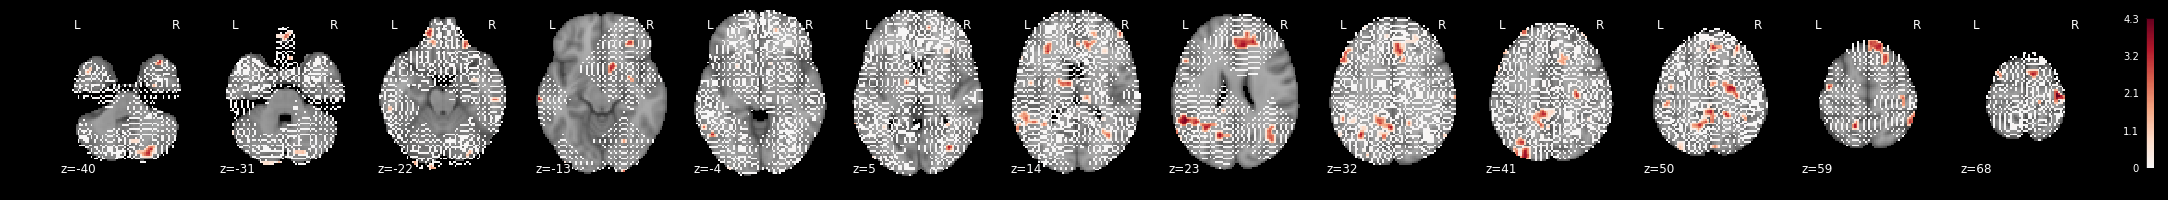

In [19]:
# plot
plotteRy_Brain('ttest_paired_mb_fb.nii.gz',threshold=1.96)

## Individual differences regression

Now we test where the difference between black-male and black-female neural pattern similarity correlates with participant stereotype overlap differences between black-male and black-female.

In [22]:
#...